In [5]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [4]:
vid = cv2.VideoCapture(0)
  
while(True):
      
    # Capture the video frame
    # by frame
    ret, frame = vid.read()
    frame_new = preprocess(frame)
    predictions = model.predict(frame_new)

    # Display the resulting frame
    cv2.imshow('frame', frame)
      
    # the 'q' button is set as the
    # quitting button you may use any
    # desired button of your choice
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
  
# After the loop release the cap object
vid.release()
# Destroy all the windows
cv2.destroyAllWindows()

In [6]:
physical_devices=tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0],True)
except:
    pass

In [7]:
tf.config.list_physical_devices('GPU')

[]

In [8]:
import gdown

In [9]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=e4677c56-372b-4461-bafe-544f130362ac
To: C:\College Material\ML\Aries Project\lip_reading\data.zip
  3%|██▎                                                                           | 12.6M/423M [00:05<03:08, 2.18MB/s]

KeyboardInterrupt: 

In [10]:
def load_video(path:str) -> List[float]:
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[196:236, 80:220, :])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [11]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!1234567890 "]

In [12]:
char_to_num = tf.keras.layers.StringLookup(vocabulary = vocab, oov_token = "")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary = char_to_num.get_vocabulary(), oov_token = "", invert = True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()}"
    f"(size = {char_to_num.vocabulary_size()})"
)


The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', ' '](size = 41)


In [13]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

  3%|██▎                                                                           | 12.6M/423M [00:20<03:08, 2.18MB/s]

In [14]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [15]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [16]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [17]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [18]:
def mappable(path:str) -> List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

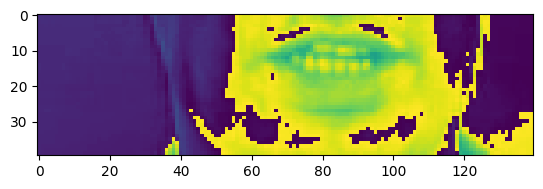

In [19]:
plt.imshow(frames[40])

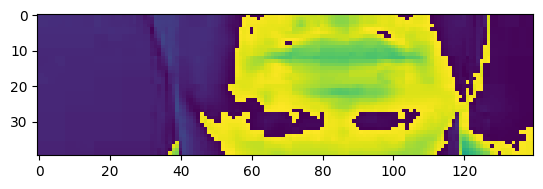

In [20]:
plt.imshow(frames[0])

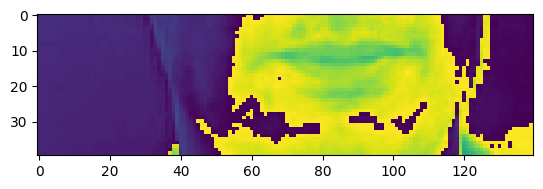

In [21]:
plt.imshow(frames[5])

In [22]:
frames[0].shape

TensorShape([40, 140, 1])

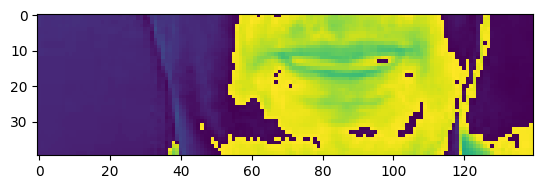

In [23]:
plt.imshow(frames[10])

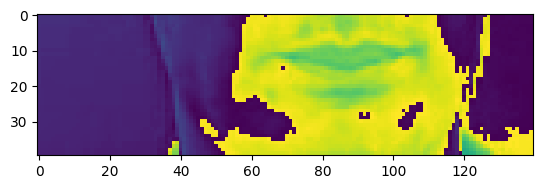

In [24]:
plt.imshow(frames[15])

In [25]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 40,  2, 12, 21,  5, 40,  1, 20, 40, 12, 40, 19,  9, 24,
       40, 14, 15, 23], dtype=int64)>

In [26]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration = False)
data = data.map(mappable)
data = data.padded_batch(2, padded_shapes = ([75,None,None,None], [40]))
data = data.prefetch(tf.data.AUTOTUNE)
train  = data.take(450)
test = data.skip(450)

In [27]:
test = data.as_numpy_iterator()

In [28]:
val = test.next(); val[0]

array([[[[[1.4004482 ],
          [1.4004482 ],
          [1.4004482 ],
          ...,
          [0.32318038],
          [0.3590893 ],
          [0.3590893 ]],

         [[1.4004482 ],
          [1.4004482 ],
          [1.4004482 ],
          ...,
          [0.32318038],
          [0.3590893 ],
          [0.3590893 ]],

         [[1.3286303 ],
          [1.3286303 ],
          [1.3286303 ],
          ...,
          [0.3590893 ],
          [0.39499822],
          [0.39499822]],

         ...,

         [[1.0772679 ],
          [1.0772679 ],
          [1.0772679 ],
          ...,
          [0.10772679],
          [0.10772679],
          [0.10772679]],

         [[1.041359  ],
          [1.041359  ],
          [1.041359  ],
          ...,
          [0.10772679],
          [0.10772679],
          [0.10772679]],

         [[1.041359  ],
          [1.041359  ],
          [1.041359  ],
          ...,
          [0.10772679],
          [0.10772679],
          [0.07181786]]],


        [[[1.4004

In [29]:
imageio.mimsave('./animation.gif', val[0][0], fps=10)

Lossy conversion from float32 to uint8. Range [0.0, 9.156777381896973]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.156777381896973]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.156777381896973]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.156777381896973]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.156777381896973]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.156777381896973]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.156777381896973]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. R

Lossy conversion from float32 to uint8. Range [0.0, 9.156777381896973]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.156777381896973]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.156777381896973]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.156777381896973]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.156777381896973]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.156777381896973]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.156777381896973]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. R

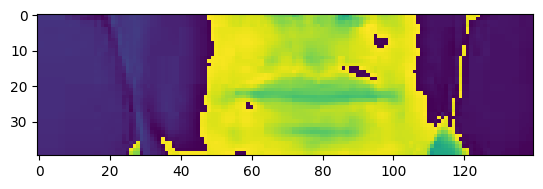

In [30]:
# 1st index returns videos, 2nd index returns video out of the batch, 3rd index returns first frame in the video
plt.imshow(val[0][0][0])

In [31]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set blue with b four please'>

In [32]:
# Neural network
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [33]:
data.as_numpy_iterator().next()[0][0].shape

(75, 40, 140, 1)

In [34]:
model=Sequential()
model.add(Conv3D(128,3,input_shape=(75,46,140,1),padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256,3,padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75,3,padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128,kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128,kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1,kernel_initializer='he_normal',activation='softmax'))

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [36]:
def scheduler(epoch,lr):
    if epoch<30:
        return lr
    else:
        return lr*tf.math.exp(-0.1)

In [37]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [38]:
def CTCLoss(y_true,y_pred):
    batch_len=tf.cast(tf.shape(y_true)[0],dtype="int64")
    input_length=tf.cast(tf.shape(y_pred)[1],dtype="int64")
    label_length=tf.cast(tf.shape(y_true)[1],dtype="int64")
    
    input_length=input_length*tf.ones(shape=(batch_len,1),dtype="int64")
    label_length=label_length*tf.ones(shape=(batch_len,1),dtype="int64")
    
    loss=tf.keras.backend.ctc_batch_cost(y_true,y_pred,input_length,label_length)
    return loss

In [39]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss=CTCLoss)

In [40]:
checkpoint_callback=ModelCheckpoint(os.path.join('models','checkpoint'),monitor='loss',save_weights_only=True)

In [41]:
schedule_callback = LearningRateScheduler(scheduler)

In [42]:
example_callback = ProduceExample(data)

In [43]:
model.fit(train, validation_data = test, epochs=100,callbacks=[checkpoint_callback,schedule_callback,example_callback])

Epoch 1/100
  7/450 [..............................] - ETA: 2:50:35 - loss: 157.5424

KeyboardInterrupt: 

In [103]:
# Validating the model
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=63b954a1-c04d-42ab-9d43-6763a7d6e9c6
To: C:\College Material\ML\Aries Project\lip_reading\checkpoints.zip
100%|█████████████████████████████████████████████████████████████████████████████| 94.5M/94.5M [00:33<00:00, 2.86MB/s]


['models\\checkpoint.index',
 'models\\__MACOSX/._checkpoint.index',
 'models\\checkpoint.data-00000-of-00001',
 'models\\__MACOSX/._checkpoint.data-00000-of-00001',
 'models\\checkpoint',
 'models\\__MACOSX/._checkpoint']

In [104]:
model.load_weights('models/checkpoint')

ValueError: You are trying to restore a checkpoint from a legacy Keras optimizer into a v2.11+ Optimizer, which can cause errors. Please update the optimizer referenced in your code to be an instance of `tf.keras.optimizers.legacy.Optimizer`, e.g.: `tf.keras.optimizers.legacy.Adam`.

In [105]:
test_data=test.as_numpy_iterator()

In [ ]:
test_data.next()

In [ ]:
sample=test_data.next()

In [ ]:
yhat=model.predict([sample[0]])

In [ ]:
decoded=tf.keras.backend.ctc_decode(yhat,input_length=[75,75],greedy=True)[0][0].numpy()

In [ ]:
print('~'*100,'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

In [ ]:
print('~'*100,'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

In [ ]:
# VIDEO TESTING
sample = load_data(tf.convert_to_tensor(frame))
yhat = model.predict(tf.expand_dims(sample[0], axis = 0))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy = True)[0][0].numpy()
print('~'*100, 'PREDICTED TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

In [ ]:
IMAGES_PATH = 'data'
number_images = 80

In [3]:
def preprocess(frame):
    # Resize the frame to match the input size of the model
    frame = cv2.resize(frame, (40, 140))
    # Convert the frame to RGB format
#     frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # Normalize the pixel values
#     frame = frame / 255.0
    # Add an extra dimension to represent the batch size
    frame = np.expand_dims(frame, axis=0)
    return frame


In [45]:
vid = cv2.VideoCapture(0)

words = []
while(True):
      
    # Capture the video frame
    # by frame
    ret, frame = vid.read()
    frame_new = preprocess(frame)
    yhat = model.predict(frame_new)
    decoded=tf.keras.backend.ctc_decode(yhat,input_length=[75,75],greedy=True)[0][0].numpy()

    # Display the resulting frame
    cv2.imshow('frame', frame)
      
    # the 'q' button is set as the
    # quitting button you may use any
    # desired button of your choice
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    for i in range(len(decoded)):
        new_word = decoded[i]
        words.append(new_word)
  
# After the loop release the cap object
vid.release()
# Destroy all the windows
cv2.destroyAllWindows()

ValueError: in user code:

    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 75, 46, 140, 1), found shape=(None, 140, 40, 3)
